## Simulating synthetic data

In [1]:
using CSV, DataFrames,  Dates, Distributions, Query
using CairoMakie, Random

In [2]:
include("../src/BayesTS/BayesTS.jl")
using .BayesTS

In [119]:
# Load helper functions 
include("../src/BayesTShelpersMulti.jl")
include("../src/DataHelpers.jl")
include("../src/ForwardSimulation.jl")
include("../src/InferenceHelpers.jl")
include("../src/lifetimes.jl")
include("../src/PosteriorHelpers.jl")
include("../src/PlotFunctions.jl")

plot_EC (generic function with 1 method)

In [4]:
# Model setup
Random.seed!(10)
T = 400 # Number of days
seed_L = 14 # Seeded days
g = generation_time(20, 5.0, 0.3)
onset = onset_time(20, 4.5, 0.6, 0.8)
g_rev = reverse(g)
onset_rev = reverse(onset)
model = SplineTrend(20, T, 4)
prior_model = [["LAS"]]

1-element Vector{Vector{String}}:
 ["LAS"]

In [ ]:
## Make R
t = collect(1:T)
X = get_design(model, t)

# Using Radial Basis Function on β for parameters
μ1 = 6
σ1 = 4
μ2 = 14
σ2 = 6
x = collect(1:size(X,2))
β1 = @. 0.4 * exp(-((x-μ1)/σ1)^2) - 0.1
β2 =  @. 0.1 * exp(-((x-μ2)/σ2)^2) + 0.1
R = exp.(X * [β1 β2])

# Inital Infections
I0 = [100., 1.]

# Generating random number of sequences each day
EN = @. 50 * exp(0.01 * t * sin(0.05 * t)) / (1 + exp(0.01 * t * sin(0.05 * t)))
N = rand.(Poisson.(EN))

# Over-dispersion and reporting rates
α = 0.1
ρ = [0.6, 0.3, 0.3, 0.7, 0.5, 0.5, 0.6]
ρ_vec = get_reporting_vector(ρ, T)

In [ ]:
fig = Figure()
ax = fig[1,1] = Axis(fig)
lines!(ax, R[:,1], color = :green)
lines!(ax, R[:,2], color = :hotpink)
fig

In [ ]:
# Simulate Epidemic
obs_counts, obs_cases, true_I, true_freq = forward_simulate_lineages(R, I0, g_rev, onset_rev, α, ρ_vec, N, seed_L)

In [ ]:
lineage_names = ["A", "B"]
state_name = "synthetic"

function make_plot_dataframe(obs_cases, obs_counts, lineage_names, state_name)
    cases = Int[]
    counts = Int[]
    obs_freqs = Float64[]
    dates = Int[]
    lineages = String[]
    lineages_num = Int[]
    state = String[]
    
    T = length(obs_cases)
    N_lineage = size(obs_counts,2)
    
    obs_freq = obs_counts ./ sum(obs_counts, dims=2)
    
    
    for lineage in 1:N_lineage
        dates = vcat(dates, collect(1:T))
        cases = vcat(cases, obs_cases)
        counts = vcat(counts, obs_counts[:, lineage])
        obs_freqs = vcat(obs_freqs, obs_freq[:, lineage])
        lineages_num = vcat(lineages_num, repeat([lineage], T))
        lineages  = vcat(lineages, repeat([lineage_names[lineage]], T))
        state = vcat(state, repeat([state_name], T))
    end
    
    return DataFrame(date = dates, cases = cases, counts = Int.(counts), obs_freqs = obs_freqs, lineage = lineages, lineage_num = lineages_num, state = state)   
end

synthetic_df = make_plot_dataframe(obs_cases, obs_counts, lineage_names, state_name)
first(synthetic_df, 10)

In [ ]:
synthetic_colors = [ "green", "hotpink"]
syn_color_vec = [synthetic_colors[i] for i in synthetic_df.lineage_num]

fig = Figure(backgroundcolor = RGBf0(1., 1., 1.), resolution = (1280, 1000), fontsize = 24)
ax1 = fig[1, 1] = Axis(fig,ylabel = "Observed Cases")
barplot!(ax1, synthetic_df.date, synthetic_df.cases, 
    color = ("black", 0.3))

ax2 = fig[2, 1] = Axis(fig,ylabel = "Observed Counts")
barplot!(ax2, synthetic_df.date, synthetic_df.counts, 
    stack = synthetic_df.lineage_num,
    color = syn_color_vec)

fig

In [ ]:
fig = Figure(backgroundcolor = RGBf0(1., 1., 1.), resolution = (1280, 800), fontsize = 24)
ax = fig[1, 1] = Axis(fig,ylabel = "Observed Frequency")

barplot!(ax, synthetic_df.date, synthetic_df.obs_freqs, 
    stack = synthetic_df.lineage_num,
    color = syn_color_vec)

fig

In [ ]:
# Export Case Counts and Observed Lineage Annotations
synthetic_df = export_dataframe_for_modeling(obs_cases, obs_counts, lineage_names, state_name)
CSV.write("../data/processed/synthetic_data.csv", synthetic_df)
first(synthetic_df, 10)

## Running model on this 

In [5]:
synthetic_df = DataFrame(CSV.File("../data/processed/synthetic_data.csv"))

,state,cases,date,sequences_total,sequences_A,sequences_B
,String,Int64,Date,Int64,Int64,Int64
1,synthetic,47,2020-01-01,19,19,0
2,synthetic,38,2020-01-02,23,23,0
3,synthetic,40,2020-01-03,23,23,0
4,synthetic,55,2020-01-04,17,17,0
5,synthetic,101,2020-01-05,19,19,0
6,synthetic,128,2020-01-06,21,20,1
7,synthetic,84,2020-01-07,24,23,1
8,synthetic,67,2020-01-08,30,29,1
9,synthetic,39,2020-01-09,22,22,0


In [6]:
# Running independent model as easy as possible
using CmdStan
ENV["JULIA_CMDSTAN_HOME"]="/Users/marlinfiggins/cmdstan/"
CmdStan.set_cmdstan_home!(ENV["JULIA_CMDSTAN_HOME"])

syn_dict = process_all_states("../src/stan_models/Rt_Structured_lineage_ind.stan", synthetic_df, 
    g, onset, 
    seed_L, 0, 
    model; priors = prior_model, 
    model_name = "synthetic")

Dict{Any, Any} with 1 entry:
  "synthetic" => Dict{String, Any}("seq_labels"=>SubString{String}["A" "B"], "s…

In [ ]:
run_stan_model!("synthetic", syn_dict)

In [7]:
load_state_samples!("synthetic", syn_dict)

8937-element Vector{String}:
 "lp__"
 "accept_stat__"
 "stepsize__"
 "treedepth__"
 "n_leapfrog__"
 "divergent__"
 "energy__"
 "b.1.1"
 "b.2.1"
 "b.3.1"
 "b.4.1"
 "b.5.1"
 "b.6.1"
 ⋮
 "obs_freqs.389.2"
 "obs_freqs.390.2"
 "obs_freqs.391.2"
 "obs_freqs.392.2"
 "obs_freqs.393.2"
 "obs_freqs.394.2"
 "obs_freqs.395.2"
 "obs_freqs.396.2"
 "obs_freqs.397.2"
 "obs_freqs.398.2"
 "obs_freqs.399.2"
 "obs_freqs.400.2"

In [ ]:
syn_dict["synthetic"]

## Plots

In [146]:
alphas = [0.6, 0.4, 0.2]
ps = [0.5, 0.8, 0.95]
#ps = [0.5, 0.8, 0.89]
lQuants = 0.5 * (1. .- ps)
uQuants = 0.5 * (1. .+ ps)
lineage_colors = [ "green", "hotpink"]

2-element Vector{String}:
 "green"
 "hotpink"

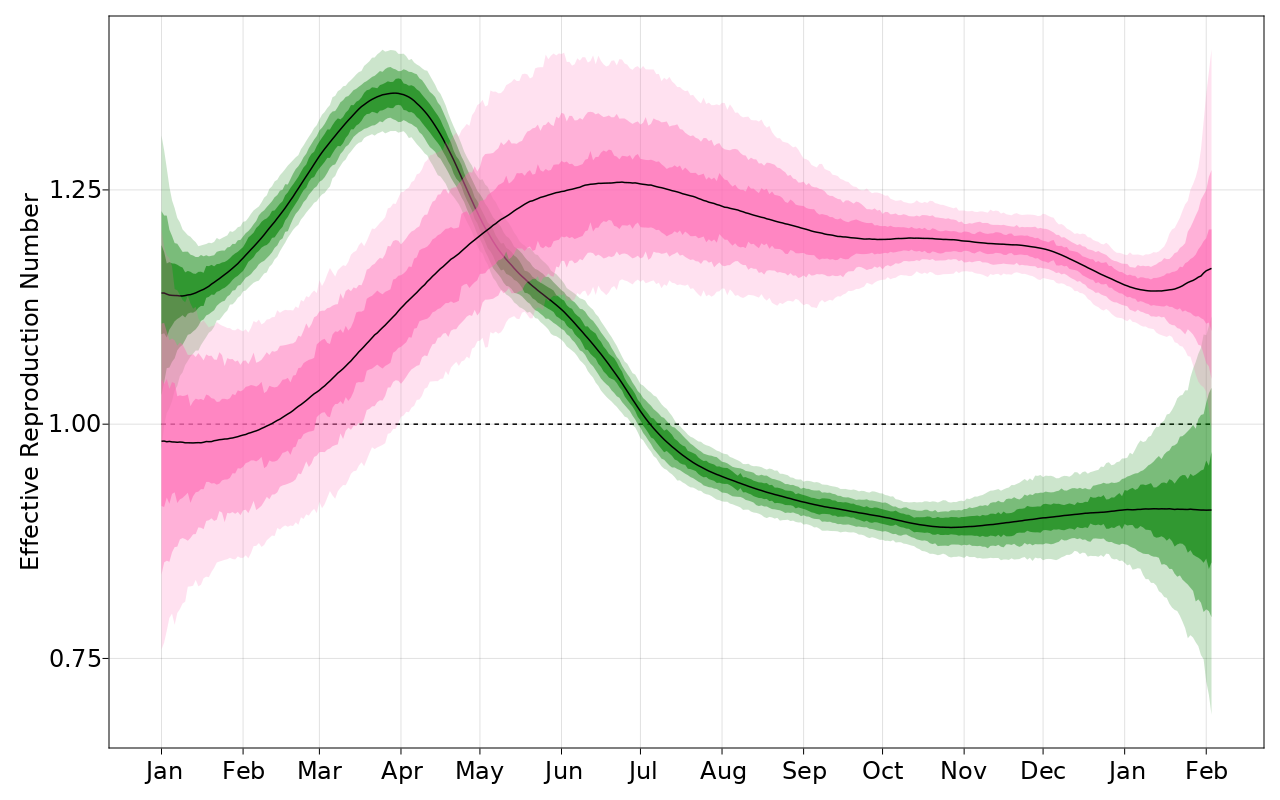

In [147]:
plot_R_HDI("synthetic", syn_dict)

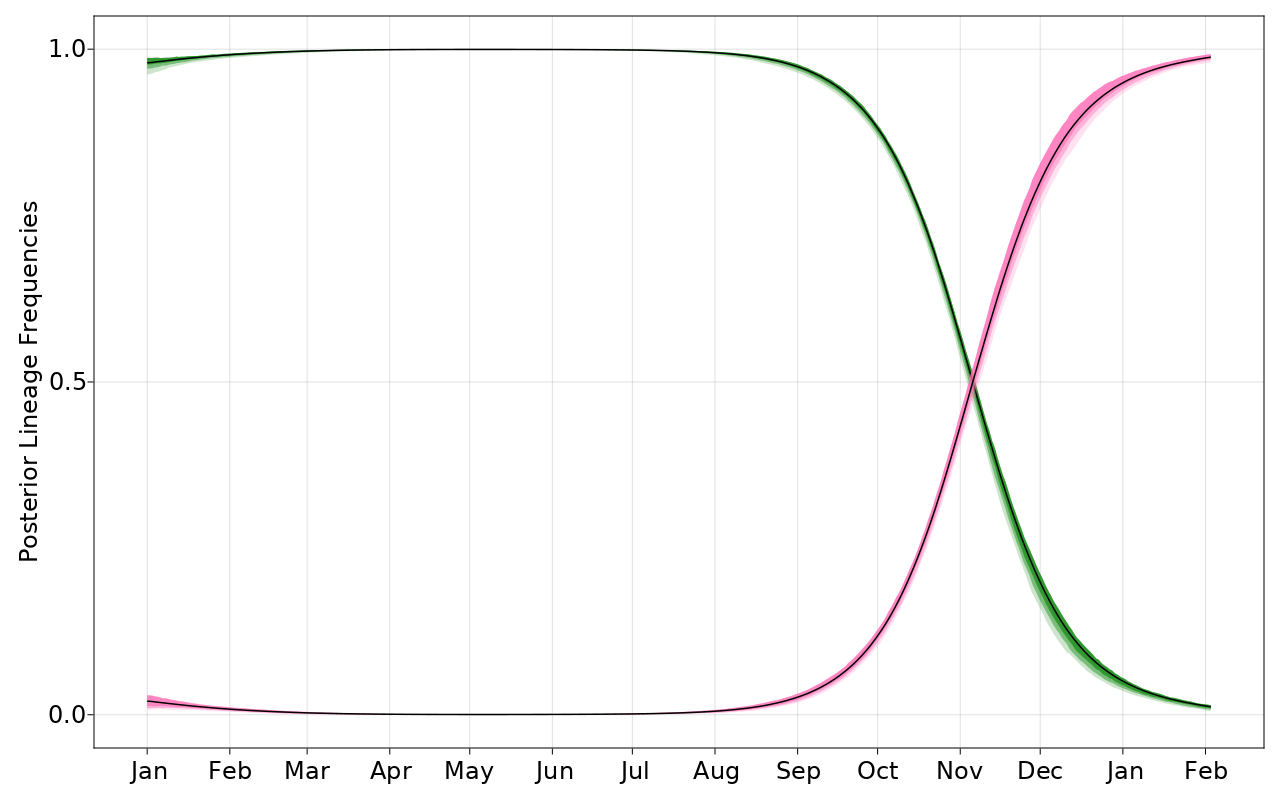

In [148]:
plot_sim_freq_HDI("synthetic", syn_dict)

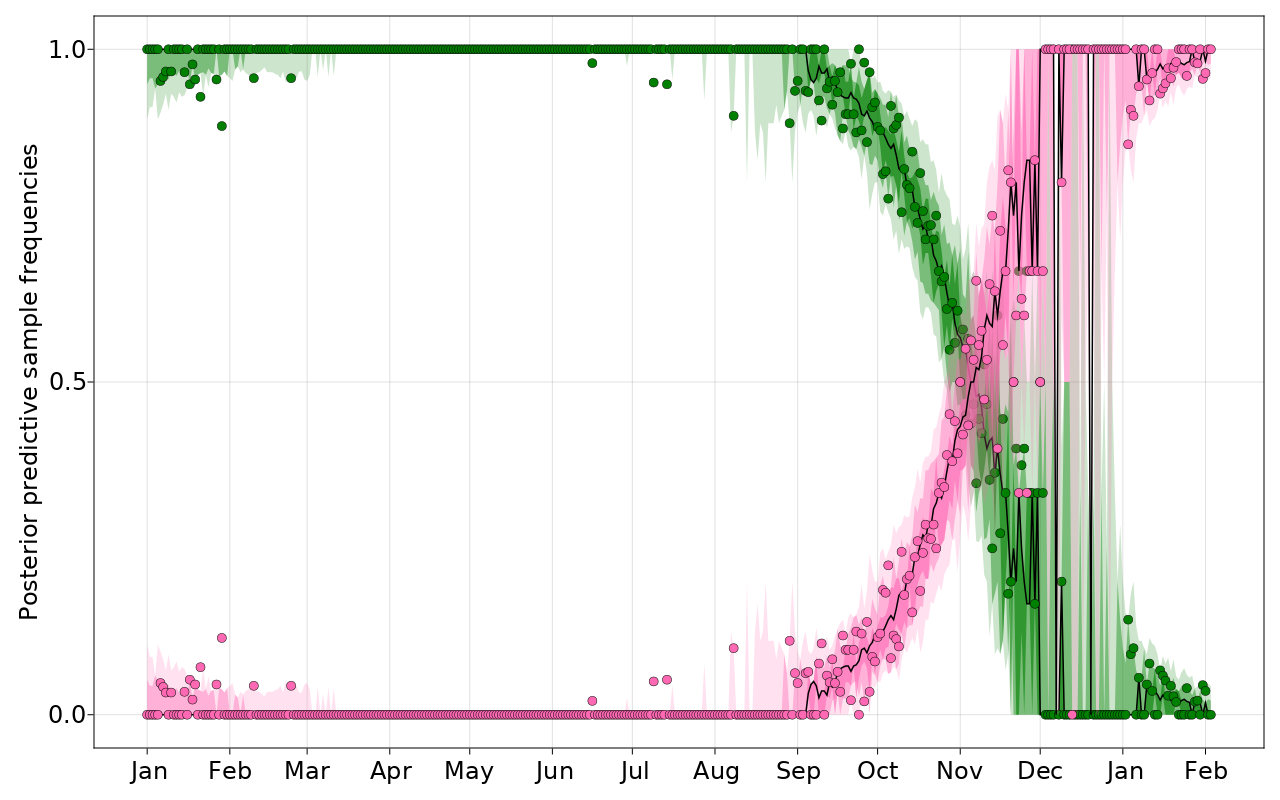

In [149]:
plot_post_pred_freq_HDI("synthetic", syn_dict)

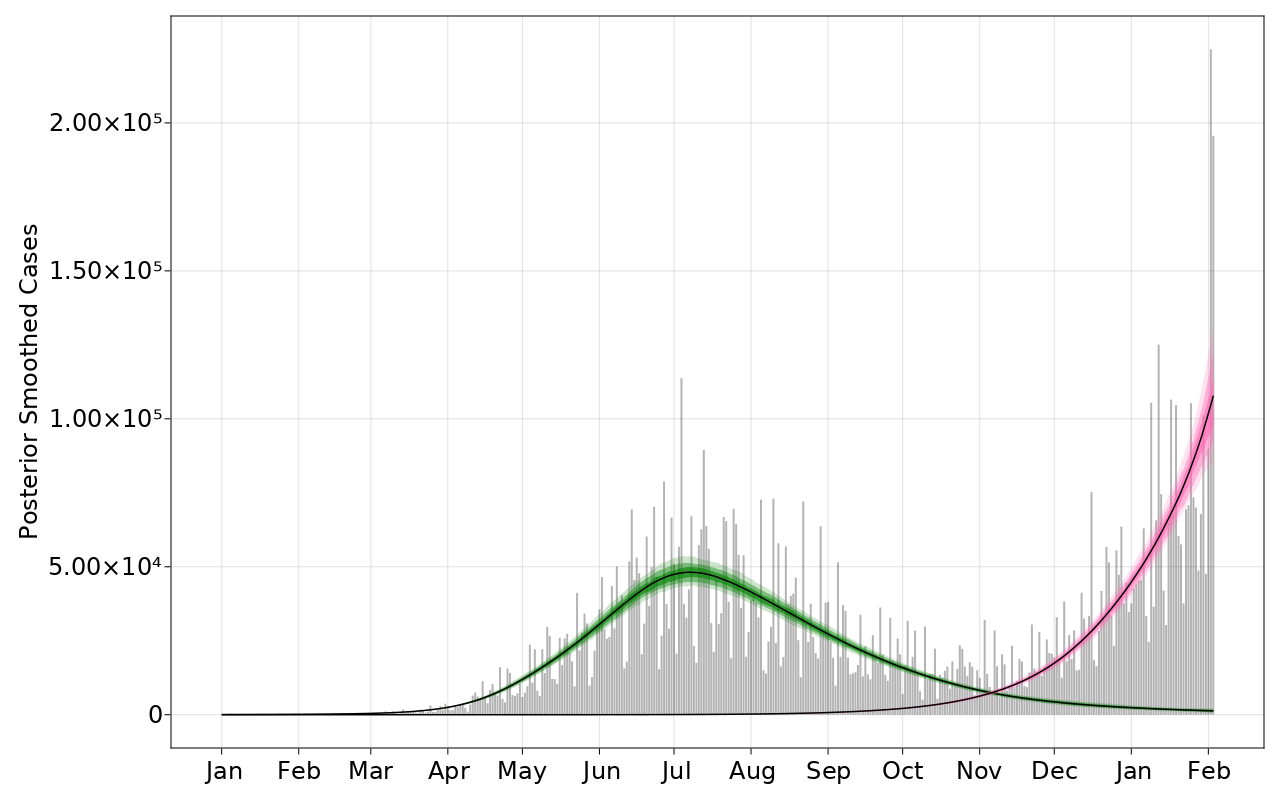

In [150]:
plot_lineage_I_prev_HDI("synthetic", syn_dict)

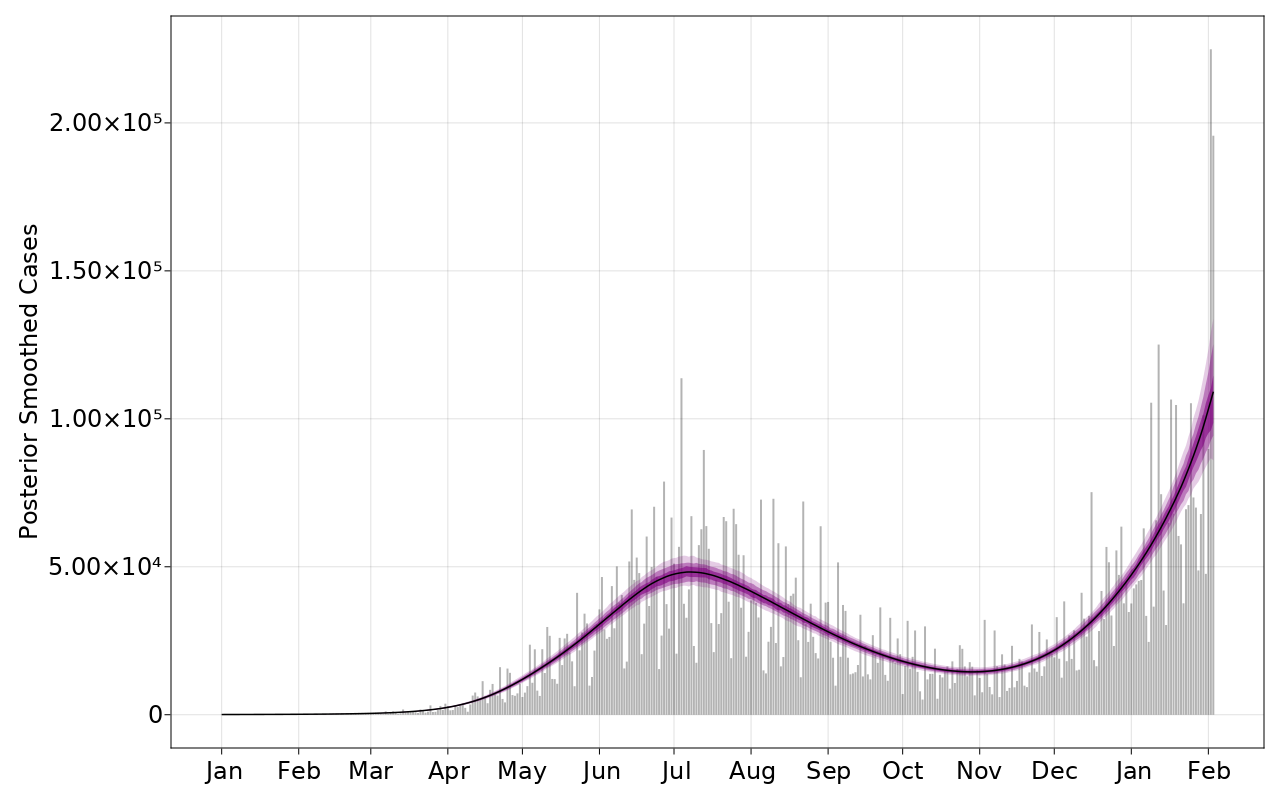

In [151]:
plot_EC_smooth_HDI("synthetic", syn_dict)

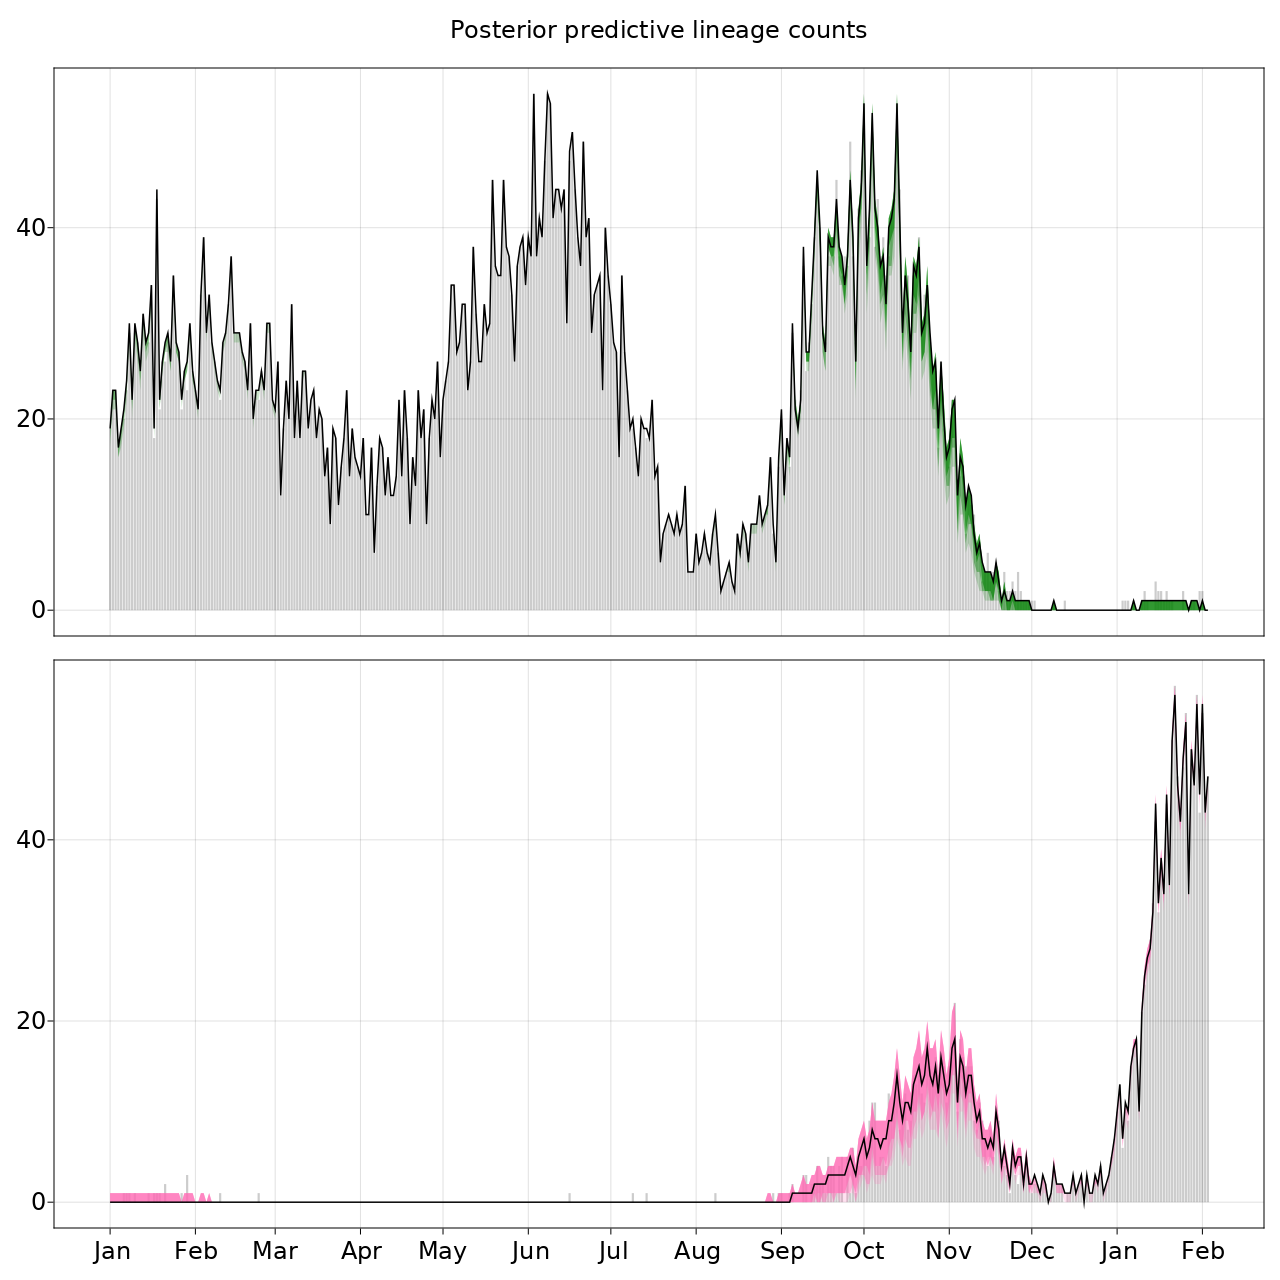

In [152]:
plot_post_pred_seq_counts_HDI("synthetic", syn_dict)

In [154]:
# We'll export both for now during the pipeline
test_r = get_Rt_by_state_HDI("synthetic", syn_dict)

,state,date,lineage,rt_median,rt_lower_50,rt_upper_50,rt_lower_80
,Any,Any,Any,Any,Float64,Float64,Float64
1,synthetic,2020-01-01,A,1.13997,1.09596,1.19114,1.0971
2,synthetic,2020-01-02,A,1.13995,1.09596,1.19114,1.0971
3,synthetic,2020-01-03,A,1.13877,1.09596,1.19114,1.0971
4,synthetic,2020-01-04,A,1.13777,1.09596,1.19114,1.0971
5,synthetic,2020-01-05,A,1.13746,1.09596,1.19114,1.0971
6,synthetic,2020-01-06,A,1.1373,1.09596,1.19114,1.0971
7,synthetic,2020-01-07,A,1.13721,1.09596,1.19114,1.0971
8,synthetic,2020-01-08,A,1.13685,1.09596,1.19114,1.0971
9,synthetic,2020-01-09,A,1.13681,1.09596,1.19114,1.0971
